In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import glob
from scipy.stats import binned_statistic, mode

In [2]:
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

ra = 0
dec = -20.

f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
        'i': 'cyan', 'z': 'orange', 'y': 'red'}



In [3]:
# OK, let's look at a few internight histograms
db_files = ['baseline_nexp2_v1.7_10yrs.db',
 'rolling_scale0.4_nslice2_v1.7_10yrs.db',
 'rolling_scale0.9_nslice2_v1.7_10yrs.db',
           '../rolling_nm/rolling_nm_scale0.4_nslice2_v1.7_10yrs.db',
           '../rolling_nm/rolling_nm_scale0.9_nslice2_v1.7_10yrs.db']

Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['night', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'filter']
Found 1570382 visits
Running:  ['baseline_nexp2_Pass_filter_observationStartMJD_fiveSigmaDepth_night_night_gt_250_and_night_lt_3102_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['night', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'filter']
Found 1570459 visits
Running:  ['rolling_scale0_4_nslice2_Pass_filter_observationStartMJD_fiveSigmaDepth_night_night_gt_250_and_night_lt_3102_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint night > 250 and night < 3102 for columns ['night', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'filter']
Fou

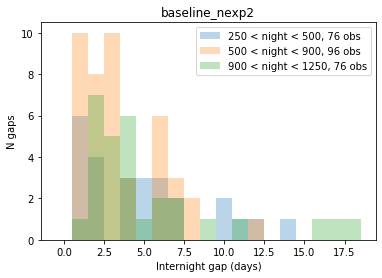

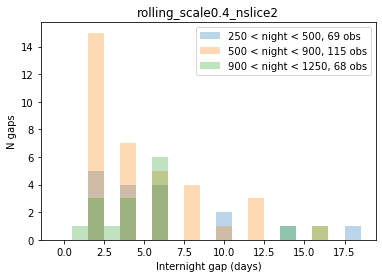

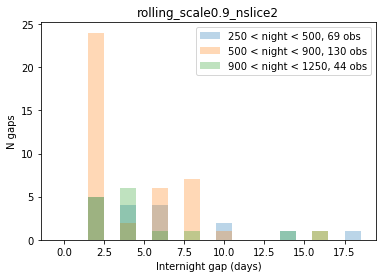

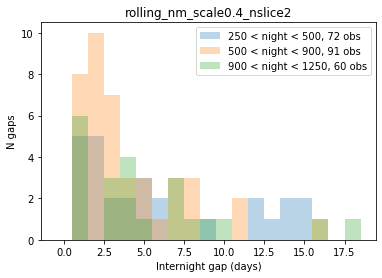

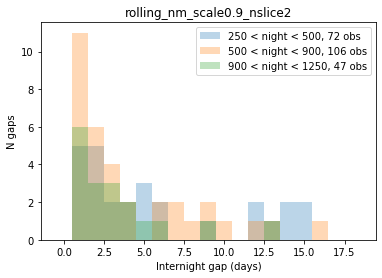

In [4]:
for filename in db_files:

    name = filename.replace('_v1.7_10yrs.db', '').split('/')[-1]

    conn = db.OpsimDatabase(filename)
    bundleList = []
    sql = 'night > 250 and night < %i' %(365*8.5)
    metric = metrics.PassMetric(['filter', 'observationStartMJD', 'fiveSigmaDepth', 'night'])
    slicer = slicers.UserPointsSlicer(ra=ra, dec=dec)
    summaryStats = []
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=name))
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    #bg.plotAll(closefigs=False)

    mv = bundleList[0].metricValues[0]
    
    plt.figure()
    unights = np.unique(mv['night'])
    bins = np.arange(0,20,1)-0.5
    breaks = np.array([250, 500, 900, 1250, 1600, 2000, 2350, 2700, 3100])
    for i in range(3):
        good = np.where((unights > breaks[i]) & (unights < breaks[i+1]))[0]
        di = np.diff(unights[good])
        total_obs = np.size(np.where((mv['night'] > breaks[i]) & (mv['night'] < breaks[i+1]))[0])
        _temp = plt.hist(di, bins=bins, label='%i < night < %i, %i obs' % (breaks[i], breaks[i+1], total_obs), alpha=0.3)
    plt.title(name)
    plt.legend()
    plt.xlabel('Internight gap (days)')
    plt.ylabel('N gaps')

* For a point on the sky, even in the baseline there is variation in the number of observations per season (76-96).  
* The regular rolling clearly has the north south modulation turned on, preventing any 1 or 3 night gaps.
* Even when the rolling strength is very strong (90%), we still have >40 observations in the off-season. Could be an issue with the rolling regions being narrow enough that the blob scheduler spills into off-season regions. Increasing weight on the footprint would probably result in more expected behavior (and in-season observations would be pushed to higher average airmass). Could also lift the attempts to keep blobs contiguous. Then we would have more in-season observations, and slightly increase mean slewtime.
* As expected, rolling increases the total number of observations in a season.
* Stats on the internight gap distribution are tough to interpret (mean gets skewed by the tail, median isn't very different between seasons). But turning on rolling results in more 1 or 2-night gaps compared to most baseline seasons.